#### Import Data Sets from the following sources and transform to one record per zip code:

* 2016 Census population estimates by zip code from factfinder.census.gov
* OSHPD hospital and emergency room utilization data by zip code from oshpd.ca.gov
* ESRI Tapestry consumer segmentation data by zip code from ESRI / ArcGIS
* CA Area Deprivation Index by zip code from https://www.neighborhoodatlas.medicine.wisc.edu/
* Schedule drug metrics by zip code from ...

#### Merge data sets into one dataframe and calculate ratios:

* Hosp and ED util per 1,000 population
* 

In [209]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as plb
import matplotlib.ticker as mtick
from scipy.stats.stats import pearsonr

In [159]:
# Read 2016 census population estimates
ca_census_pop_2016_df = pd.read_csv("ACS_16_5YR_B01003_with_ann.csv",skiprows=1)
ca_census_df = ca_census_pop_2016_df[['Id2','Estimate; Total']]
ca_census_df = ca_census_df.rename(columns={'Id2':'Zip','Estimate; Total':'2016_Census_Pop_Est'})

# drop non-CA zips
ca_census_df = ca_census_df.drop([0,1,2,3,4,5]) # NV zips

#ca_census_df.count()
ca_census_df.head()

,Zip,2016_Census_Pop_Est
6,90001,57942
7,90002,51826
8,90003,70208
9,90004,63095
10,90005,39338


In [164]:
# Read 2016 census population estimates with some age/sex detail
ca_census_demo_df = pd.read_csv("ACS_16_5YR_DP05_with_ann.csv",skiprows=1)
ca_census_demo_df = ca_census_demo_df.rename(columns={'Id2':'Zip','Estimate; Total':'2016_Census_Pop_Est'})

# drop non-CA zips
ca_census_demo_df = ca_census_demo_df.drop([0,1,2,3,4,5]) # NV zips
#ca_census_demo_df.head()

In [154]:
# Read 2016 CA OSHPD Utilization file
ca_hosp_2016_df = pd.read_csv("POMS2016.csv")

# Limit to data that can be aggregated by pt zip code
ca_hosp_2016_df = ca_hosp_2016_df[['pzip','pcounty','year','pattype','discharges']]

# Use groupby to summarize discharges by pzip, pcounty, year and pattype
ca_hosp_2016_df = ca_hosp_2016_df.groupby(['pzip','pcounty','year','pattype']).sum()
ca_hosp_2016_df = ca_hosp_2016_df.reset_index()
ca_hosp_2016_df = ca_hosp_2016_df.set_index(['pzip','pcounty','year'])
ca_hosp_2016_df = ca_hosp_2016_df.pivot_table(index=['pzip','pcounty','year'], columns='pattype',values='discharges').reset_index()

# drop records with no zip code (ie. ARIZONA, HOMELESS, etc in pzip column)
ca_hosp_2016_df = ca_hosp_2016_df.drop([2672,2673,2674,2675,2676,2677,2678])

# convert pzip from string to int
ca_hosp_2016_df['pzip'] = ca_hosp_2016_df['pzip'].apply(pd.to_numeric)

#ca_hosp_2016_df.count()
ca_hosp_2016_df.head()

pattype,pzip,pcounty,year,AS Only,ED Only,Inpatient,Inpatient from ED
0,90001,LOS ANGELES,2016,1798.0,24554.0,3628.0,3286.0
1,90002,LOS ANGELES,2016,1661.0,25168.0,3421.0,3314.0
2,90003,LOS ANGELES,2016,2111.0,32061.0,4610.0,4648.0
3,90004,LOS ANGELES,2016,2115.0,15820.0,2751.0,2639.0
4,90005,LOS ANGELES,2016,1107.0,8650.0,1579.0,1488.0


In [157]:
# Read Tapestry segments by CA zip
tapestry_df = pd.read_csv("Tapestry_by_CA_Zip.csv")
tapestry_df.head()

,ZIP Code,NAME,Dominant Tapestry Segment Number per Zip,Dominant Tapestry Segment Code per Zip,Dominant Tapestry Segment Name per Zip,Dominant Lifemode Code,Dominant Lifemode Group Name
0,90001.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave
1,90002.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave
2,90003.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave
3,90004.0,Los Angeles,60.0,13A,International Marketplace,13.0,Next Wave
4,90005.0,Los Angeles,62.0,13C,NeWest Residents,13.0,Next Wave


In [192]:
ca_adi_df = pd.read_csv("CA_ADI_by_ZIP.csv")
ca_adi_df.head()

,Zip,ADI_STATERNK,ADI_NATRANK
0,90001,8.007138,45.794018
1,90002,8.125497,50.517541
2,90003,7.972540,46.906751
3,90004,4.238019,28.200175
4,90005,7.225923,57.775878


In [160]:
drug_metrics_df = pd.read_csv("schedule_drugs_table2_metrics_by_year_and_zip.csv")

# create dataframe with only 2016 drug data
drug_metrics_2016_df = drug_metrics_df.loc[drug_metrics_pd['xYear']==2016]

#drug_metrics_df.sort_values('Zip')

# what % of records are unique Zips
drug_metrics_2016_df['Zip'].nunique()/drug_metrics_2016_df['Zip'].count()

drug_metrics_2016_df.head()

,xYear,State,County,Zip,rundatetime,Rx_count_Pat,Rx_count_Pph,Rx_count_Dis,Pat_count,PillCount_Total_Pph,...,RegCount_Pph,RegCount_Dis,PatCount_MultiDisp,PatCount_MultiRxer,InqCount_Pph,InqCount_Dis,PphCount_RxBenzoOpioid,PatCount_Rx90MME,PatCount_Rx40Methadone,Population
0,2016,CA,Los Angeles,90001,01APR2018:11:21:17,7879,985,7653,4202,35588.00,...,12,13,2,230,176,29934,7,37,0,"57,110"
1,2016,CA,Los Angeles,90002,01APR2018:11:21:17,10927,995,6483,5072,44514.00,...,22,5,1,300,166,3423,4,10,0,"51,223"
2,2016,CA,Los Angeles,90003,01APR2018:11:21:17,12814,1527,484,6073,69210.00,...,40,14,3,334,861,782,6,80,1,"66,266"
3,2016,CA,Los Angeles,90004,01APR2018:11:21:17,7149,4442,3318,3987,227289.04,...,44,29,0,197,7701,15497,16,222,11,"62,180"
4,2016,CA,Los Angeles,90005,01APR2018:11:21:17,4292,1655,1579,2342,27805.00,...,24,21,1,116,359,9942,4,9,0,"37,681"


In [195]:
combo1_df = ca_census_pd.merge(ed_visits_by_zip_tmp6, left_on='Zip', right_on='pzip', how='outer')

# Add Ambulatory Surgery (AS), Emergency Dept (ED), Inpatient (discharges) and Inpatient from ED utilization rates per 1,000 pop
combo1_df['AS per 1,000'] = combo1_df['AS Only'] / combo_df['2016_Census_Pop_Est']
combo1_df['ED per 1,000'] = combo1_df['ED Only'] / combo_df['2016_Census_Pop_Est']
combo1_df['IP per 1,000'] = combo1_df['Inpatient'] / combo_df['2016_Census_Pop_Est']
combo1_df['IP via ED per 1,000'] = combo1_df['Inpatient from ED'] / combo_df['2016_Census_Pop_Est']

combo1_df.head()

# what % of records are unique Zips
combo1_df['Zip'].nunique()/combo1_df['Zip'].count()

1.0

In [196]:
combo2_df = combo1_df.merge(tapestry_df, left_on='Zip', right_on='ZIP Code', how='outer')
combo2_df.head()

combo3_df = combo2_df.merge(ca_adi_df, on='Zip', how='outer')
combo3_df.head()

,Zip,2016_Census_Pop_Est,pzip,pcounty,year,AS Only,ED Only,Inpatient,Inpatient from ED,"AS per 1,000",...,"IP via ED per 1,000",ZIP Code,NAME,Dominant Tapestry Segment Number per Zip,Dominant Tapestry Segment Code per Zip,Dominant Tapestry Segment Name per Zip,Dominant Lifemode Code,Dominant Lifemode Group Name,ADI_STATERNK,ADI_NATRANK
0,90001.0,57942.0,90001.0,LOS ANGELES,2016.0,1798.0,24554.0,3628.0,3286.0,0.031031,...,0.056712,90001.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave,8.007138,45.794018
1,90002.0,51826.0,90002.0,LOS ANGELES,2016.0,1661.0,25168.0,3421.0,3314.0,0.032050,...,0.063945,90002.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave,8.125497,50.517541
2,90003.0,70208.0,90003.0,LOS ANGELES,2016.0,2111.0,32061.0,4610.0,4648.0,0.030068,...,0.066203,90003.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave,7.972540,46.906751
3,90004.0,63095.0,90004.0,LOS ANGELES,2016.0,2115.0,15820.0,2751.0,2639.0,0.033521,...,0.041826,90004.0,Los Angeles,60.0,13A,International Marketplace,13.0,Next Wave,4.238019,28.200175
4,90005.0,39338.0,90005.0,LOS ANGELES,2016.0,1107.0,8650.0,1579.0,1488.0,0.028141,...,0.037826,90005.0,Los Angeles,62.0,13C,NeWest Residents,13.0,Next Wave,7.225923,57.775878


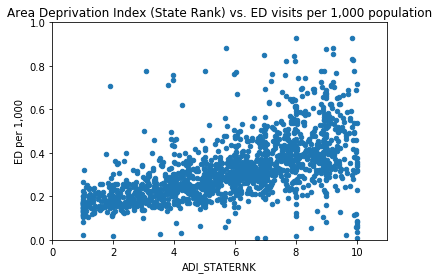

In [218]:
combo3_df.plot(x='ADI_STATERNK', y='ED per 1,000', kind='scatter', xlim=(0,11), ylim=(0,1), title='Area Deprivation Index (State Rank) vs. ED visits per 1,000 population')


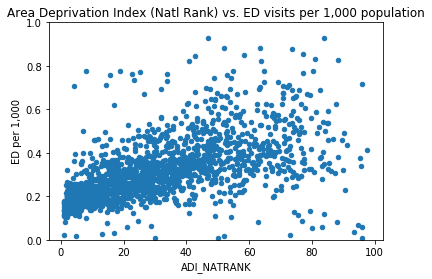

In [207]:
combo3_df.plot(x='ADI_NATRANK', y='ED per 1,000', kind='scatter', ylim=(0,1), title='Area Deprivation Index (Natl Rank) vs. ED visits per 1,000 population')

In [146]:
combo3_df = combo2_df.merge(drug_metrics_2016_pd, on='Zip', how='outer')
combo_nulls = combo3_df[combo3_df.isnull().any(axis=1)]

# what % of records are unique Zips
combo3_df['Zip'].nunique()/combo3_df['Zip'].count()

combo3_df.head()

,Zip,2016_Census_Pop_Est,pzip,pcounty,year,AS Only,ED Only,Inpatient,Inpatient from ED,"AS per 1,000",...,RegCount_Pph,RegCount_Dis,PatCount_MultiDisp,PatCount_MultiRxer,InqCount_Pph,InqCount_Dis,PphCount_RxBenzoOpioid,PatCount_Rx90MME,PatCount_Rx40Methadone,Population
0,90001.0,57942.0,90001.0,LOS ANGELES,2016.0,1798.0,24554.0,3628.0,3286.0,0.031031,...,12.0,13.0,2.0,230.0,176.0,29934.0,7.0,37.0,0.0,"57,110"
1,90002.0,51826.0,90002.0,LOS ANGELES,2016.0,1661.0,25168.0,3421.0,3314.0,0.032050,...,22.0,5.0,1.0,300.0,166.0,3423.0,4.0,10.0,0.0,"51,223"
2,90003.0,70208.0,90003.0,LOS ANGELES,2016.0,2111.0,32061.0,4610.0,4648.0,0.030068,...,40.0,14.0,3.0,334.0,861.0,782.0,6.0,80.0,1.0,"66,266"
3,90004.0,63095.0,90004.0,LOS ANGELES,2016.0,2115.0,15820.0,2751.0,2639.0,0.033521,...,44.0,29.0,0.0,197.0,7701.0,15497.0,16.0,222.0,11.0,"62,180"
4,90005.0,39338.0,90005.0,LOS ANGELES,2016.0,1107.0,8650.0,1579.0,1488.0,0.028141,...,24.0,21.0,1.0,116.0,359.0,9942.0,4.0,9.0,0.0,"37,681"
